# Convolutional Neural Network
- Previous makemore notebooks looked at a multi level perceptron (MLP) character level language model.
- The model recives 3 previous characters and tries to predict the next character in the sequence.
- Let's complexify this, take more characters in the input, and make a deeper model. The model will look like a WaveNet.
- See the 2016 WaveNet article [here](https://arxiv.org/pdf/1609.03499). It uses a tree like structure. Their model uses dilated casual convolutions.
- A casual convolution ensures that the prediction at time step t depends only on previous time steps. This is critical for autoregressive models, where each sample is generated based on past samples. To enforce casuality, a convolutional filter is *masked* to prevent future inputs from contribution to the current output.
- A dialed convolution introduces gaps between filter elments. This allows the model to have a larger receptive field without increasing the number of parameters. The network can capture long-term dependencies efficently.

In [217]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import random
random.seed(42)

# read all the words
words = open('names.txt').read().splitlines()
print(f'number of words: {len(words)}')
print(f'length of smallest word: {min(len(w) for w in words)}')
print(f'length of longest word: {max(len(w) for w in words)}')
print(f'first words: {words[:8]}')

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(f'mapping: {itos=}')
print(f'vocab size: {vocab_size}')

# shuffle up the words
random.shuffle(words)

# build the dataset
block_size = 8  # context length: how many characters do we take to predict the next one?
def build_dataset(strs):
    X, Y = [], []
    for w in strs:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f'{X.shape=}, {Y.shape=}')
    return X, Y

num_words = len(words)
n1 = int(0.8*num_words)
n2 = int(0.9*num_words)
 
Xtr, Ytr = build_dataset(words[:n1])      # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])      # 10%

# let's look at some examples
print('\nfist examples:')
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

number of words: 32033
length of smallest word: 2
length of longest word: 15
first words: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
mapping: itos={1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocab size: 27
X.shape=torch.Size([182625, 8]), Y.shape=torch.Size([182625])
X.shape=torch.Size([22655, 8]), Y.shape=torch.Size([22655])
X.shape=torch.Size([22866, 8]), Y.shape=torch.Size([22866])

fist examples:
........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [ ]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):  
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5  # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    # this layer has state

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True  
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)  # like batch norm gain, set to ones by default
        self.beta = torch.zeros(dim)  # like batch norm bias, set to zeros by default
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # forward pass
        if self.training:
            if x.ndim == 2:  # if x is a 2D tensor, we'll reduce over dimension 0 only
                dim = 0
            elif x.ndim == 3:  # if x is a 3D tensor, we'll reduce over dimensions 0 and 1
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)  # batch mean
            xvar = x.var(dim, keepdim=True, unbiased=True)  # batch variance
        else:  # we are testing/inferencing
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta  # calculating output of layer, pytorch does not have self.out
        # update the buffers
        if self.training:
            with torch.no_grad(): 
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

# torhch also has a torch.nn.Embedding 
class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        # this will be C
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        # indexing operation in forward pass
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

# torch also has a torch.nn.Flatten
class Flatten:

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []
    
# torch also has a torch.nn.Flatten but it is different than the definition here
class FlattenConsecutive:

    # n will be the number of elements that are consecutive 
    # that we would like to concatenate in the last dimension of the output
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape  # num_examples, num_chars, c
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:  # T//self.n is a spurious dimension
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []
    
"""
[Pytorch Containers](https://pytorch.org/docs/stable/nn.html#containers)
- containers are a way of oraganizing layers into lists or dicts
- a [sequential container](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) organizes the layers into a list
"""
class Sequential:

    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]


In [219]:
torch.manual_seed(42)

In [220]:
n_embd = 24  # the dimensionality of the character embedding vectors
n_hidden = 128  # the number of neurons in the hidden layer of the MLP

# replace the embedding matrix C with the 2 layers, Embedding and Faltten
#C = torch.randn((vocab_size, n_embd))
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),  
    Linear(n_hidden, vocab_size),
])

# parameters init
with torch.no_grad():
    model.layers[-1].weight *= 0.1  # last layer make less confident

#parameters = [C] + [p for layer in layers for p in layer.parameters()]
#parameters = [p for layer in layers for p in layer.parameters()]
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

76579


In [229]:
def flatten_exercise():
    n_embd_10 = 10  # the dimensionality of the character embedding vectors
    n_hidden_200 = 200 
    model = Sequential([
        Embedding(vocab_size, n_embd_10),
        Flatten(),  # same as FlattenConsecutive(block_size)
        Linear(n_embd_10 * block_size, n_hidden_200, bias=False), BatchNorm1d(n_hidden_200), Tanh(), 
        Linear(n_hidden_200, vocab_size),
    ])
    
    print('let\'s look at a batch of just 4 examples')
    ix = torch.randint(0, Xtr.shape[0], (4,))  # batch of just 4 examples
    Xb, Yb = Xtr[ix], Ytr[ix]
    logits = model(Xb)
    print(f'{Xb.shape=}')
    print('each example is a row of Xb consisting of the indices of the 8 characters')
    print(f'{Xb=}')
    print()
    print('\noutput of embedding layer')
    print('the embedding layer plucks out the embedding vector for each integer and organizes in a 4, 8, 10 tensor')
    print('so all the integers are translated into 10 dimensional vectors, inside this 3 dimensional tensor ')
    print(f'{model.layers[0].out.shape=}')

    print('\noutput of flatten layer')
    print('all the 10 dimensional vectors stretch out, aka concatenated, to 4,80')
    print(f'{model.layers[1].out.shape=}')
    
    print('\noutput of linear layer')
    print(f'{model.layers[2].out.shape=}')
    print('what comes out of the linear layer? X @ W + b')
    print(f'{(torch.randn(4, 80) @ (torch.randn(80,200) + torch.randn(200))).shape=}')

    print('\nmatrix multiplication occurs on the last dimension 80, and the other dimensions in the input tensor are left unchanged, aka treated as batch dimensions')
    print(f'{(torch.randn(4, 5, 2, 80) @ (torch.randn(80,200) + torch.randn(200))).shape=}')
    
    print('\nwe can group the 8 characters as so, aka introduce batch dimensions, and process in parallel: (1 2) (3 4) (5 6) (7, 8)')
    print('X will by 4 examples, 4 groups of 2, 20 (8 chracters into 10 dimensions / 4 groups is 20)')
    print(f'{(torch.randn(4, 4, 20) @ (torch.randn(20,200) + torch.randn(200))).shape=}')
    print()

    print('so right now we have a 4, 8, 10 that feeds into the flatten layer')
    print('and we want (4, 4, 20) where consecutive 10-d vectors get concatenated')
    e = torch.randn(4, 8, 10)
    print(f'{e.view(4, -1).shape=}')
    print('explictly grab the even parts, the odd parts, concatenate them along the 2nd dimension')
    explicit_concatenation = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
    print(f'{explicit_concatenation.shape=}')
    print(f'{(e.view(4, 4, 20) == explicit_concatenation).all()=}')
flatten_exercise()

let's look at a batch of just 4 examples
Xb.shape=torch.Size([4, 8])
each example is a row of Xb consisting of the indices of the 8 characters
Xb=tensor([[ 0,  0,  3, 15, 18,  2,  1, 14],
        [ 0,  0,  0,  9, 22,  9, 15, 14],
        [ 0, 19, 14,  9, 20,  8,  9, 11],
        [ 0,  0,  0,  0,  0,  0,  1, 14]])


output of embedding layer
the embedding layer plucks out the embedding vector for each integer and organizes in a 4, 8, 10 tensor
so all the integers are translated into 10 dimensional vectors, inside this 3 dimensional tensor 
model.layers[0].out.shape=torch.Size([4, 8, 10])

output of flatten layer
all the 10 dimensional vectors stretch out, aka concatenated, to 4,80
model.layers[1].out.shape=torch.Size([4, 80])

output of linear layer
model.layers[2].out.shape=torch.Size([4, 200])
what comes out of the linear layer? X @ W + b
(torch.randn(4, 80) @ (torch.randn(80,200) + torch.randn(200))).shape=torch.Size([4, 200])

matrix multiplication occurs on the last dimension 80, a

In [228]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 1000 == 0:  # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3122
   1000/ 200000: 1.9835
   2000/ 200000: 2.2231
   3000/ 200000: 2.0480
   4000/ 200000: 1.8958
   5000/ 200000: 2.2423
   6000/ 200000: 2.0337
   7000/ 200000: 2.6564
   8000/ 200000: 1.9555
   9000/ 200000: 2.2131
  10000/ 200000: 1.8319
  11000/ 200000: 2.3072
  12000/ 200000: 2.1284
  13000/ 200000: 2.2798
  14000/ 200000: 1.7417
  15000/ 200000: 2.4498
  16000/ 200000: 2.3532
  17000/ 200000: 2.2944
  18000/ 200000: 1.7940
  19000/ 200000: 1.6990
  20000/ 200000: 1.6818
  21000/ 200000: 2.5673
  22000/ 200000: 1.9817
  23000/ 200000: 2.5205
  24000/ 200000: 1.8612
  25000/ 200000: 2.1886
  26000/ 200000: 2.2456
  27000/ 200000: 2.4716
  28000/ 200000: 1.9116
  29000/ 200000: 2.3207
  30000/ 200000: 1.8369
  31000/ 200000: 2.0883
  32000/ 200000: 1.6881
  33000/ 200000: 2.0019
  34000/ 200000: 2.2884
  35000/ 200000: 2.1047
  36000/ 200000: 2.0296
  37000/ 200000: 1.8343
  38000/ 200000: 1.9498
  39000/ 200000: 1.8597
  40000/ 200000: 2.0347
  41000/ 200000:

len(lossi)=200000
loss_means.shape=torch.Size([200])


Text(0.5, 1.0, 'average log loss')

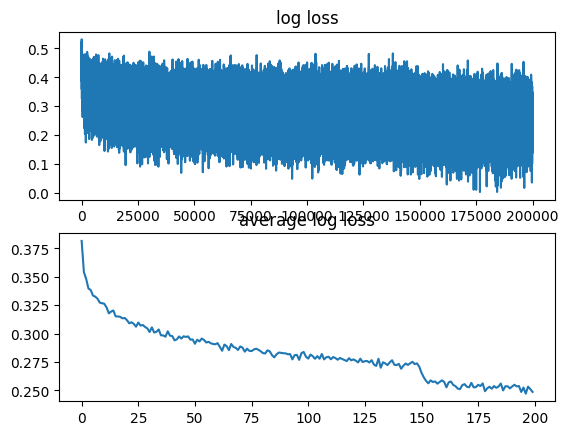

In [230]:
plt.subplot(2, 1, 1)
plt.plot(lossi)
plt.title('log loss')

# put list of lossi into a tensor
# and then stretch this into rows where each row is 1000 consecutive elements
# and then take the mean of each row, aka 1st dimension
print(f'{len(lossi)=}')
loss_means = torch.tensor(lossi).view(-1, 1000).mean(1)
print(f'{loss_means.shape=}')

plt.subplot(2, 1, 2)
plt.plot(loss_means)
plt.title('average log loss')

# if see a drop at the end, that's the learning rate decay

In [231]:
# put layers into eval mode (needed for batchnorm)
for layer in model.layers:
    layer.training = False
# MAKE SURE TO DO THIS!!! BATCHNORM HAS A STATE!!!

In [232]:
def print_model_shapes(m):
    for layer in m.layers:
        print(layer.__class__.__name__, ':', tuple(layer.out.shape))

In [233]:
# evaluation
@torch.no_grad()  # this decorator disables gradient tracking on this function
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': {Xdev, Ydev},
        'test': {Xte, Yte},
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
print()

print_model_shapes(model)

train 1.7654955387115479
val 1.992987871170044

Embedding : (22655, 8, 24)
FlattenConsecutive : (22655, 4, 48)
Linear : (22655, 4, 128)
BatchNorm1d : (22655, 4, 128)
Tanh : (22655, 4, 128)
FlattenConsecutive : (22655, 2, 256)
Linear : (22655, 2, 128)
BatchNorm1d : (22655, 2, 128)
Tanh : (22655, 2, 128)
FlattenConsecutive : (22655, 256)
Linear : (22655, 128)
BatchNorm1d : (22655, 128)
Tanh : (22655, 128)
Linear : (22655, 27)


# performance log

## 3 character context
### Details
- 3 block size
- 10 number of character embedding vectors
- 200 hidden neurons
- 12K parameters
```
model = Sequential([
        Embedding(vocab_size, n_embd),
        Flatten(),  # same as FlattenConsecutive(block_size)
        Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
        Linear(n_hidden, vocab_size),
    ])
```
### Evaluation
- train 2.123889207839966
- val 2.1750588417053223

-------------------------------------------------------------------------------------------

## Increase to 8 character context
### Details
- 8 block size
- 10 number of character embedding vectors
- 200 hidden neurons
- 22K parameters
- same model as above, but block size was increased to 8
- 1.5 minutes training time
### Evaluation
- train 1.9826093912124634
- val 2.0902533531188965
### Layer Shapes
- Embedding : (22655, 8, 10)
- Flatten : (22655, 80)
- Linear : (22655, 200)
- BatchNorm1d : (22655, 200)
- Tanh : (22655, 200)
- Linear : (22655, 27)

-------------------------------------------------------------------------------------------

## use 1 FlattenConsecutive layer with n of block_size which is 8, expect similar performance as previous
### Details
- use 1 FlattenConsecutive layer with n of block_size of 8
- expect similar performance as previous
- 1 minute training time
```
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(block_size),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    Linear(n_hidden, vocab_size),
])
```
### Evaluation
- train 1.9827793836593628
- val 2.0879368782043457
### Layers shapes
- Embedding : (22655, 8, 10)
- FlattenConsecutive : (22655, 80)
- Linear : (22655, 200)
- BatchNorm1d : (22655, 200)
- Tanh : (22655, 200)
- Linear : (22655, 27)

-------------------------------------------------------------------------------------------

## Model wtih 3 Flatten Cosnecutive layers
### Details
- 8 block size
- 10 number of character embedding vectors
- 200 hidden neurons
- This is a much bigger model with 170K parameters
- training time was 5 minutes
```
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),  
    Linear(n_hidden, vocab_size),
])
```
### Evaluation
- train 1.8118302822113037
- val 2.0630011558532715
### Layer shapes
- Embedding : (22655, 8, 10)
- FlattenConsecutive : (22655, 4, 20)
- Linear : (22655, 4, 200)
- BatchNorm1d : (22655, 4, 200)
- Tanh : (22655, 4, 200)
- FlattenConsecutive : (22655, 2, 400)
- Linear : (22655, 2, 200)
- BatchNorm1d : (22655, 2, 200)
- Tanh : (22655, 2, 200)
- FlattenConsecutive : (22655, 400)
- Linear : (22655, 200)
- BatchNorm1d : (22655, 200)
- Tanh : (22655, 200)
- Linear : (22655, 27)

-------------------------------------------------------------------------------------------

## Model with 68 hidden nuerons, 22K parameters
### Details
- 8 block size
- 10 number of character embedding vectors
- 68 hidden neurons
- 22397 parameters
- same model as above
- 3 minutes training time
### Evaluation
- train 1.9597235918045044
- val 2.073059558868408
### Layer Shapes
- Embedding : (22655, 8, 10)
- FlattenConsecutive : (22655, 4, 20)
- Linear : (22655, 4, 68)
- BatchNorm1d : (22655, 4, 68)
- Tanh : (22655, 4, 68)
- FlattenConsecutive : (22655, 2, 136)
- Linear : (22655, 2, 68)
- BatchNorm1d : (22655, 2, 68)
- Tanh : (22655, 2, 68)
- FlattenConsecutive : (22655, 136)
- Linear : (22655, 68)
- BatchNorm1d : (22655, 68)
- Tanh : (22655, 68)
- Linear : (22655, 27)

-------------------------------------------------------------------------------------------

## Scale up the network, increase n_embd, n_hidden
- 8 block size
- 24 number of character embedding vectors
- 128 hidden neurons
- 76579 parameters
- same model as above
- 4 minutes training time
### Evaluation
- train 1.765776515007019
- val 1.9896525144577026
### Layer shapes
- Embedding : (22655, 8, 24)
- FlattenConsecutive : (22655, 4, 48)
- Linear : (22655, 4, 128)
- BatchNorm1d : (22655, 4, 128)
- Tanh : (22655, 4, 128)
- FlattenConsecutive : (22655, 2, 256)
- Linear : (22655, 2, 128)
- BatchNorm1d : (22655, 2, 128)
- Tanh : (22655, 2, 128)
- FlattenConsecutive : (22655, 256)
- Linear : (22655, 128)
- BatchNorm1d : (22655, 128)
- Tanh : (22655, 128)
- Linear : (22655, 27)

In [234]:
# sample from the model

for _ in range(20):
    out = []
    context = [0] * block_size # init with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special token '.', then break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

amayah.
zeva.
michael.
knopbel.
saem.
yasleigh.
brexley.
damilo.
elia.
alewan.
rosley.
linlynn.
saban.
rosameena.
keidy.
zacharionna.
kalesidy.
mannia.
kailon.
kairin.


So why convolutional neural networks?

In [216]:
def why_cnn():
    print('take one name with 8 examples in it')
    for x, y in zip(Xtr[7:15], Ytr[7:15]):
        print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])
    print(f'\n{Xtr[7].shape=}')
    print('\nget extra batch dimension')
    print(f'{Xtr[[7]].shape=}')
    print('\nforward a single example')
    logits = model(Xtr[[7]])
    print(f'{logits.shape=}')
    print('\nforward all 8 examples with a for loop')
    logits = torch.zeros(8, 27)
    for i in range(8):
        logits[i] = model(Xtr[[7+i]])
    print(f'{logits.shape=}')
    print('this is 8 indpenednet calls to the model')
    print('\nCNN will hide this for loop in kernels in Cuda, so more efficient!')
    print('think of the convolutional as a for loop applying a linear filter over space of some input sequence')
    print('we are interested in sliding these filters over some input data')

why_cnn()

take one name with 8 examples in it
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .

Xtr[7].shape=torch.Size([8])

get extra batch dimension
Xtr[[7]].shape=torch.Size([1, 8])

forward a single example
logits.shape=torch.Size([1, 27])

forward all 8 examples with a for loop
logits.shape=torch.Size([8, 27])
this is 8 indpenednet calls to the model

CNN will hide this for loop in kernels in Cuda, so more efficient!
think of the convolutional as a for loop applying a linear filter over space of some input sequence
we are interested in sliding these filters over some input data


# torch.nn
- We have implemented many torch.nn layers and containers on top of torch.tensor. Going forward, we'll use torch.nn modules.

# Development Process
- We spend a lot of time in documentation.
- There are a lot of gymnastics figuring out all the shapes, multi-dimemsional shapes. Is it NCL, CNL? Are you permutting? viewing? Prototyping occurs in Jupyter notebook to check the shapes. Then kick off experiment in code repository.

# experimental harness
- We need to set up an evluation harness. We'll look at plots of training and validation losses. We'll do hyperparameter searches. How to set this up and make it good is its own topic.

# Recurring neural networks, Transformer
- To cover in future